### Visualize the experiment results

In [ ]:
import os
import re
import pandas as pd

# Path to the MOT20-train directory
path = "/media/hbai/data/code/LITE/results/scenarios/hotas" # path you evaluated the MOT results
pattern = r"^(.*?)__input_(\d+)__conf_(\d*\.\d+)$"

# Initialize a list to store results
combined_results = []

# Loop through each subfolder
for folder in os.listdir(path):
    match = re.match(pattern, folder)
    if match:
        TrackerName, input_res, conf_threshold = match.groups()
        
        # Path to the result file
        result_file = os.path.join(path, folder, "pedestrian_summary.txt")
        
        if os.path.isfile(result_file):
            with open(result_file, "r") as f:
                # Read columns and values
                columns = f.readline().strip().split()
                values = f.readline().strip().split()
                
                # Add tracker settings to the results data
                result_data = {
                    "TrackerName": TrackerName,
                    "InputResolution": int(input_res),
                    "ConfidenceThreshold": float(conf_threshold)
                }
                result_data.update(dict(zip(columns, map(float, values))))
                
                combined_results.append(result_data)

# Convert combined results into a DataFrame
combined_df = pd.DataFrame(combined_results)
combined_df

In [ ]:
import matplotlib.pyplot as plt
import itertools
# Assuming 'comparison_df' is defined and has the necessary data

# List of distinct trackers
trackers = ['DeepSORT', 'LITEDeepSORT', 'SORT', 'StrongSORT']
# More markers can be added if needed
markers = itertools.cycle(('o', 's', 'D', '^', 'v', '<', '>', 'P', '*'))
line_styles = itertools.cycle(('-', '--', '-.', ':'))

# Assigning a color to each tracker
color_map = {tracker: plt.cm.tab10(i) for i, tracker in enumerate(trackers)}

resolutions = sorted(combined_df['InputResolution'].unique())

# Set consistent style for all plots
plt.rcParams['lines.linewidth'] = 6  # Thicker lines
plt.rcParams['legend.fontsize'] = 20  # Larger legend font size

for res in resolutions:
    df = combined_df[combined_df['InputResolution'] == res]

    # Smaller figure size
    plt.figure(figsize=(9, 5))  # Adjust the size to fit your page better

    for tracker in trackers:
        subset = df[df['TrackerName'] == tracker]
        # Sort by confidence for plotting
        subset = subset.sort_values(by='ConfidenceThreshold')
        plt.plot(subset['ConfidenceThreshold'], subset['HOTA'],
                 marker=next(markers), linestyle=next(line_styles),
                 label=tracker, color=color_map[tracker])

     # Set font size for x and y labels
    plt.xlabel('Confidence Threshold', fontsize=20)
    plt.ylabel('HOTA Score', fontsize=20)
    plt.title(f'Input Resolution {res}x{res}', fontsize=22)

    # Set font size for x and y ticks
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Set the x and y axis limits
    plt.xlim(0, 0.8)
    plt.ylim(2, 32)

    # Place the legend on the bottom left
    if res < 1280:
            plt.legend(loc='upper right')
    else:
            plt.legend(loc='lower left')

    plt.grid(True)
    plt.tight_layout()
    # Save the plots to the specified directory with a DPI suitable for high-quality printing
    plt.savefig(f'MOT20-plots/effect_of_det_settings_on_HOTA_{res}x{res}_MOT20.png', dpi=300)
    plt.show()
    #plt.close()  # Close the plot to avoid displaying it inline if using a notebook

### Plot HOTA and FPS of trackers in MOT17 and MOT20 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for both MOT17 and MOT20
data = {
    "Tracker": [
        "SORT", "OCSORT", "DeepSORT", "LITE:DeepSORT" , "DeepOCSORT",
        "LITE:DeepOCSORT", "BoTSORT", "LITE:BoTSORT", "StrongSORT", "ByteTrack"
    ],
    "MOT17_HOTA": [40.3, 43.9, 43.7,  43.0,  43.7,  43.7, 40.9, 40.8, 41.7, 43.8],
    "MOT17_FPS": [32.0, 28.8, 13.7,  28.3,  10.6,  27.9, 19.1, 30.7, 5.1, 29.7],
    "MOT20_HOTA": [20.1, 25.2, 24.8,  25.2,  24.9,  25.3, 20.8, 21.1, 24.8, 25.2],
    "MOT20_FPS": [27.0, 24.2, 5.5,  23.4,  7.2,  22.7, 14.3, 24.2, 2.7, 24.4]
}

# Define color and shape mappings with exact naming match
color_map = {
    "SORT": "blue", "DeepSORT": "green", "LITE:DeepSORT": "green",
    "OCSORT": "gray", "DeepOCSORT": "yellow", "LITE:DeepOCSORT": "yellow",
    "BoTSORT": "orange", "LITE:BoTSORT": "orange",
    "StrongSORT": "purple", "ByteTrack": "red"
}

shape_map = {
    "SORT": "o", "DeepSORT": "o", "LITE:DeepSORT": "s",
    "OCSORT": "o", "DeepOCSORT": "o", "LITE:DeepOCSORT": "s",
    "BoTSORT": "o", "LITE:BoTSORT": "s",
    "StrongSORT": "o", "ByteTrack": "o"
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting for MOT17 and MOT20
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Function to plot data with border and line connection
def plot_data(ax, dataset, title):
    # Plot each tracker with specified color, shape, and black border
    for i, row in df.iterrows():
        sns.scatterplot(
            x=[row[f"{dataset}_HOTA"]],
            y=[row[f"{dataset}_FPS"]],
            color=color_map[row["Tracker"]],
            marker=shape_map[row["Tracker"]],
            s=800,
            edgecolor="black",  # Black border around points
            linewidth=1.5,
            label=row["Tracker"] if row["Tracker"] not in ax.get_legend_handles_labels()[1] else "",
            ax=ax
        )

    # Draw lines between each LITE tracker and its counterpart
    pairs = [("DeepSORT", "LITE:DeepSORT"), ("DeepOCSORT", "LITE:DeepOCSORT"), ("BoTSORT", "LITE:BoTSORT")]
    for pair in pairs:
        tracker1, tracker2 = pair
        row1 = df[df["Tracker"] == tracker1]
        row2 = df[df["Tracker"] == tracker2]
        ax.plot([row1[f"{dataset}_HOTA"].values[0], row2[f"{dataset}_HOTA"].values[0]],
                [row1[f"{dataset}_FPS"].values[0], row2[f"{dataset}_FPS"].values[0]],
                color='black', linestyle="--", linewidth=1.5)

    # Customize plot
    ax.set_title(f"{title} Tracker Performance", weight='bold', fontsize=26)
    ax.set_xlabel("HOTA", fontsize=25, fontweight='bold')
    ax.set_ylabel("FPS", fontsize=25, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=25)
    if dataset == "MOT17":
        ax.set_xticks(range(40, 45, 1))
    ax.get_legend().remove()

# Plot MOT17
plot_data(axes[0], "MOT17", "MOT17")

# Plot MOT20
plot_data(axes[1], "MOT20", "MOT20")

# Adjust layout and set legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, columnspacing=1.5, labelspacing=1.5, borderpad=1.5, frameon=True, fontsize=23, edgecolor="black", framealpha=1, fancybox=False, shadow=False)

plt.tight_layout(rect=[0, 0.28, 1, 1])  # Space at the bottom for legend
plt.show()

# Visualize conf vs HOTA results

In [ ]:
import os
import re
import matplotlib.pyplot as plt

imgsz = 1280

# Define the directory path
base_dir = f'../results/MOT17-train_{imgsz}_evaluated'

# List of trackers with their line styles and colors
tracker_styles = {
    "DeepOCSORT": {"line_style": '--', "color": 'violet'},   # Purple
    "LITEDeepOCSORT": {"line_style": '--', "color": 'b'},  # Orange
    "BoTSORT": {"line_style": '-.', "color": 'brown'},          # Red
    "LITEBoTSORT": {"line_style": '-.', "color": 'r'},   # Brown
    "LITEDeepSORT": {"line_style": '--', "color": 'orange'},   # Gray
    "SORT": {"line_style": ':', "color": 'gray'},               # Blue
    "OCSORT": {"line_style": ':', "color": 'cyan'},        # Cyan
    "Bytetrack": {"line_style": ':', "color": 'g'},        # Green
    # "StrongSORT": {"line_style": ':', "color": 'magenta'}, # Magenta
}

# Dictionary to store confidence values and HOTA scores for each tracker
tracker_data = {key: {"conf": [], "hota": []} for key in tracker_styles.keys()}

# Loop through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue
    
    # Check if the folder matches any of the tracker names
    for tracker in tracker_styles.keys():
        if re.match(rf'^{tracker}__input_{imgsz}__conf_\d+\.\d+$', folder):
            # Extract confidence value from the folder name
            match = re.search(r'conf_(\d+\.\d+)', folder)
            if match:
                conf = float(match.group(1))
                
                # Path to pedestrian_summary.txt
                summary_file = os.path.join(folder_path, 'pedestrian_summary.txt')
                
                # Check if the file exists
                if os.path.isfile(summary_file):
                    # Read the file and get the HOTA value
                    with open(summary_file, 'r') as f:
                        f.readline()  # Skip the header line
                        line = f.readline().strip()  # Read the values line
                        
                        # Split the line by spaces and take the first value as HOTA
                        try:
                            hota = float(line.split()[0])
                            # Append confidence and HOTA to the tracker's lists
                            tracker_data[tracker]["conf"].append(conf)
                            tracker_data[tracker]["hota"].append(hota)
                        except ValueError as e:
                            print(f"Error reading HOTA in {summary_file}: {e}")
            break  # Stop checking other trackers if a match is found

# Plot HOTA vs. Confidence for all trackers in one plot
plt.figure(figsize=(12, 8))

# Plot each tracker with its specified line style and color
for tracker, data in tracker_data.items():
    if data["conf"] and data["hota"]:  # Check if there's data to plot
        # Sort data by confidence values
        sorted_data = sorted(zip(data["conf"], data["hota"]))
        conf_values, hota_values = zip(*sorted_data)

        # Get line style and color from the tracker styles
        line_style = tracker_styles[tracker]["line_style"]
        color = tracker_styles[tracker]["color"]
        if 'LITE' in tracker:
            marker = 'D'
        else:
            marker = 'o'
        plt.plot(conf_values, hota_values, marker=marker, linestyle=line_style, color=color, label=tracker, linewidth=8)

# Add labels, title, legend, and grid
plt.xlabel('Confidence Threshold', fontsize=25, weight='bold')
plt.ylabel('HOTA Score', fontsize=25, weight='bold')
plt.xticks(fontsize=25)  # Adjust x-axis font size
plt.yticks(fontsize=25)  # Adjust y-axis font size
plt.title(f'Input Resolution {imgsz}x{imgsz} on Jetson Orin NX', fontsize=26)
plt.legend(fontsize=20, ncol=2)
# save the plot
plt.savefig(f'hota_vs_conf_input_{imgsz}_MOT17.png')
plt.show()

# Visualize conf vs FPS results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

imgsz = 640

# Load the CSV file
file_path = f"../results/MOT17-FPS_{imgsz}/MOT17-02-FRCNN/fps.csv"
data = pd.read_csv(file_path)

# Define styles for each tracker
tracker_styles = {
    "DeepOCSORT": {"line_style": '--', "color": 'violet'},  
    "LITEDeepOCSORT": {"line_style": '--', "color": 'b'},  
    "BoTSORT": {"line_style": '-.', "color": 'brown'},       
    "LITEBoTSORT": {"line_style": '-.', "color": 'r'},       
    "LITEDeepSORT": {"line_style": '-', "color": 'orange'}, 
    "SORT": {"line_style": ':', "color": 'gray'},             
    "OCSORT": {"line_style": ':', "color": 'cyan'},           
    "Bytetrack": {"line_style": ':', "color": 'g'},           
}

# Plotting
plt.figure(figsize=(12, 8))

# Plot each tracker using the specified line style and color, in the order of tracker_styles
for tracker, style in tracker_styles.items():
    tracker_data = data[data['tracker_name'] == tracker]
    sorted_data = tracker_data.sort_values(by='conf')
    
    line_style = style["line_style"]
    color = style["color"]
    marker = 'D' if 'LITE' in tracker else 'o'

    # Plot confidence vs FPS
    plt.plot(
        sorted_data['conf'], 
        sorted_data['FPS'], 
        marker=marker, 
        linestyle=line_style, 
        color=color, 
        label=tracker, 
        linewidth=2.5
    )

# Add labels, title, and legend in specified order
plt.xlabel('Confidence Threshold', fontsize=25, weight='bold')
plt.ylabel('Frames Per Second', fontsize=25, weight='bold')
plt.title(f'Input Resolution {imgsz}x{imgsz} on Jetson Orin NX', fontsize=26)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20, ncol=2)
# save the plot
plt.savefig(f'fps_vs_conf_input_{imgsz}_MOT17.png')
plt.show()


# Plot HOTA and FPS of trackers in MOT17 and MOT20 Jetson Orin results

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

imgsz_values = [640, 1280]

# Define tracker styles
tracker_styles = {
    "DeepOCSORT": {"line_style": '--', "color": 'violet'},  
    "LITEDeepOCSORT": {"line_style": '--', "color": 'b'},  
    "BoTSORT": {"line_style": '-.', "color": 'brown'},       
    "LITEBoTSORT": {"line_style": '-.', "color": 'r'},       
    "LITEDeepSORT": {"line_style": '-', "color": 'orange'}, 
    "SORT": {"line_style": ':', "color": 'gray'},             
    "OCSORT": {"line_style": ':', "color": 'cyan'},           
    "Bytetrack": {"line_style": ':', "color": 'g'},           
}

# Create a figure with four subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(24, 16), sharey='row')
# fig.subplots_adjust(hspace=0.3) 

# Loop through each imgsz and plot both HOTA vs Confidence and FPS vs Confidence
for i, imgsz in enumerate(imgsz_values):
    # HOTA vs Confidence (Row 1)
    base_dir = f'../results/MOT17-train_{imgsz}_evaluated'
    tracker_data = {key: {"conf": [], "hota": []} for key in tracker_styles.keys()}

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder) 
        if not os.path.isdir(folder_path):
            continue
        
        for tracker in tracker_styles.keys():
            if re.match(rf'^{tracker}__input_{imgsz}__conf_\d+\.\d+$', folder):
                match = re.search(r'conf_(\d+\.\d+)', folder)
                if match:
                    conf = float(match.group(1))
                    summary_file = os.path.join(folder_path, 'pedestrian_summary.txt')
                    if os.path.isfile(summary_file):
                        with open(summary_file, 'r') as f:
                            f.readline()  
                            line = f.readline().strip()  
                            try:
                                hota = float(line.split()[0])
                                tracker_data[tracker]["conf"].append(conf)
                                tracker_data[tracker]["hota"].append(hota)
                            except ValueError as e:
                                print(f"Error reading HOTA in {summary_file}: {e}")
                break  

    ax_hota = axes[0, i]
    for tracker, data in tracker_data.items():
        if data["conf"] and data["hota"]:
            sorted_data = sorted(zip(data["conf"], data["hota"]))
            conf_values, hota_values = zip(*sorted_data)
            style = tracker_styles[tracker]
            marker = 'D' if 'LITE' in tracker else 'o'
            ax_hota.plot(conf_values, hota_values, marker=marker, 
                         linestyle=style["line_style"], color=style["color"], 
                         label=tracker, linewidth=8)
    ax_hota.set_title(f'HOTA vs Confidence Resolution {imgsz}x{imgsz}', fontsize=24)
    ax_hota.set_xlabel('Confidence Threshold', fontsize=24)
    ax_hota.tick_params(axis='both', labelsize=22)
    ax_hota.grid(True)  # Add grid
    if i == 0:
        ax_hota.set_ylabel('HOTA Score', fontsize=24)

    # FPS vs Confidence (Row 2)
    fps_file = f"../results/MOT17-FPS_{imgsz}/MOT17-02-FRCNN/fps.csv"
    data = pd.read_csv(fps_file)

    ax_fps = axes[1, i]
    for tracker, style in tracker_styles.items():
        tracker_data = data[data['tracker_name'] == tracker]
        sorted_data = tracker_data.sort_values(by='conf')
        marker = 'D' if 'LITE' in tracker else 'o'
        ax_fps.plot(
            sorted_data['conf'], sorted_data['FPS'], 
            marker=marker, linestyle=style["line_style"], 
            color=style["color"], label=tracker, linewidth=8
        )
    ax_fps.set_title(f'FPS vs Confidence Resolution {imgsz}x{imgsz}', fontsize=24)
    ax_fps.set_xlabel('Confidence Threshold', fontsize=24)
    ax_fps.tick_params(axis='both', labelsize=22)
    ax_fps.grid(True)  # Add grid
    if i == 0:
        ax_fps.set_ylabel('Frames Per Second', fontsize=24)

# Add a single legend for all plots, at the bottom
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=26, ncol=4)

# Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0.08, 1, 1])
# Adjust spacing between rows and columns
fig.subplots_adjust(hspace=0.3, wspace=0.05, bottom=0.15)  # Increased hspace for rows, set bottom margin for legend

plt.savefig('hota_fps_vs_conf_MOT17_side_by_side.png')
plt.show()


# Get HOTA and other metrics to make results table

In [ ]:
import os

# Directory where the trackers are stored
base_dir = '/home/hbai/LITE/results/MOT17-train_1280_evaluated/'

# Initialize a dictionary to store the results for each tracker
metrics_summary = {}

# Loop through each tracker folder in the base directory
for tracker_folder in os.listdir(base_dir):
    # Construct the path to pedestrian_summary.txt
    if "0.25" not in tracker_folder:
        continue
    summary_file_path = os.path.join(base_dir, tracker_folder, 'pedestrian_summary.txt')
    
    # Check if the file exists
    if os.path.isfile(summary_file_path):
        with open(summary_file_path, 'r') as f:
            # Read the data line by line
            lines = f.readlines()
            
            # Header line for metrics (assuming it's the first line)
            headers = lines[0].strip().split()
            
            # Values line (assuming it's the second line)
            values = lines[1].strip().split()
            
            # Convert values to floats for easier manipulation if needed
            values = list(map(float, values))
            
            # Create a dictionary for the metrics in this file
            metrics = dict(zip(headers, values))
            
            # Extract the required metrics
            metrics_summary[tracker_folder] = {
                'HOTA': metrics['HOTA'],
                'IDF1': metrics['IDF1'],
                'MOTA': metrics['MOTA'],
                'AssA': metrics['AssA'],
                'DetA': metrics['DetA']
            }

# Print the extracted metrics
for tracker, metrics in metrics_summary.items():
    print(f"{tracker.split('__')[0].rjust(20, ' ')}: & {metrics['HOTA']:.1f} & {metrics['IDF1']:.1f} & {metrics['MOTA']:.1f} & {metrics['AssA']:.1f} & {metrics['DetA']:.1f}")


# Visualize GT detection and tracks of MOT17 and MOT20

In [26]:
import cv2
import pandas as pd
import os
import random

# Full Paths
gt_path = '../datasets/MOT17/train/MOT17-02-FRCNN/gt/gt.txt' # path to the ground truth file

img_folder = '../datasets/MOT17/train/MOT17-02-FRCNN/img1/' # path to the image folder

# Load ground truth data
gt_data = pd.read_csv(gt_path, header=None)
gt_data.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'visibility']

# Sort by frame number and filter visible objects
gt_data = gt_data.sort_values(by='frame')

# Assign a random color to each object ID
id_colors = {}
unique_ids = gt_data['id'].unique()
for obj_id in unique_ids:
    id_colors[obj_id] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Video writer
first_frame = cv2.imread(os.path.join(img_folder, '000001.jpg'))
height, width, _ = first_frame.shape
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

# Iterate over frames
for frame_num in sorted(gt_data['frame'].unique()):


    frame_path = os.path.join(img_folder, f'{frame_num:06d}.jpg')
    frame = cv2.imread(frame_path)

    if frame is None:
        continue

    # Get all boxes for the current frame
    frame_data = gt_data[gt_data['frame'] == frame_num]

    for _, row in frame_data.iterrows():
        if row['class'] != 1:
         continue

        x, y, w, h = int(row['x']), int(row['y']), int(row['w']), int(row['h'])
        obj_id = int(row['id'])
        visibility = row['visibility']

        # Get color for the current object ID
        color = id_colors[obj_id]

        # Draw bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

        # Add text for ID and visibility level
        text = f'ID: {obj_id}, Vis: {visibility:.2f}'
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(frame)
    cv2.imshow('Tracking', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
out.release()
cv2.destroyAllWindows()


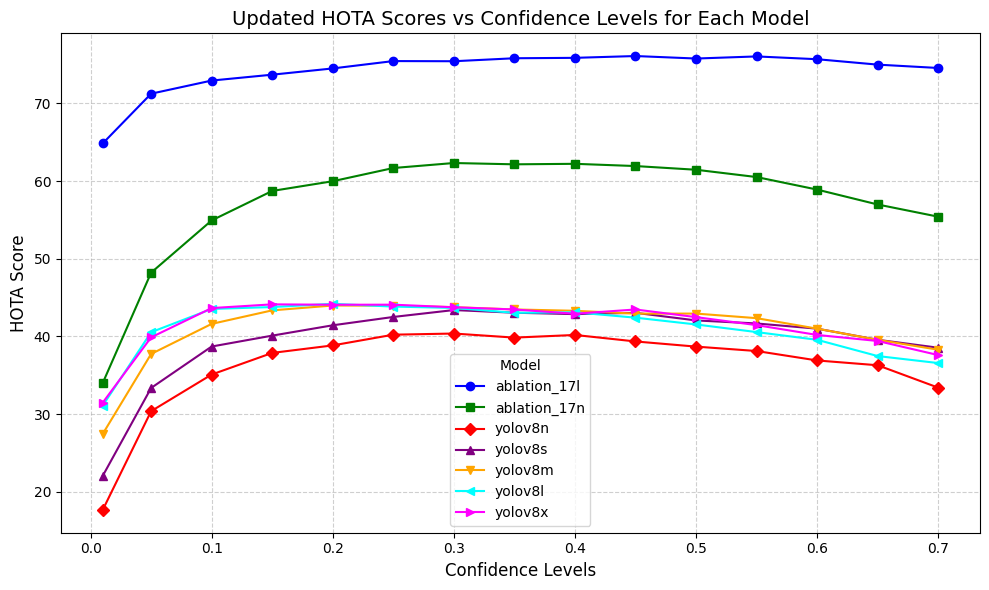

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df_updated = pd.read_csv("combined_data.csv")
df_updated = df_updated[df_updated['dataset']=='MOT17-train']
models = df_updated["model"].unique()
colors = ["blue", "green", "red", "purple", "orange", "cyan", "magenta", "brown", "gray", "olive"]
markers = ["o", "s", "D", "^", "v", "<", ">", "P", "*", "X"]

sorted_data_updated = {model: df_updated[df_updated["model"] == model].sort_values(by="conf") for model in models}

# Plotting the updated data
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    data = sorted_data_updated[model]
    plt.plot(data["conf"], data["HOTA"], label=model, marker=markers[i % len(markers)], color=colors[i % len(colors)])

# Customizing the plot
plt.title("Updated HOTA Scores vs Confidence Levels for Each Model", fontsize=14)
plt.xlabel("Confidence Levels", fontsize=12)
plt.ylabel("HOTA Score", fontsize=12)
plt.legend(title="Model", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the updated plot
plt.show()